# ***`ODOMETER CLASSIFICATION USING TRODO DATASET`***




# 1- Download and extract the dataset


mount the drive for accessing dataset

You can access the dataset from following link:
https://data.mendeley.com/datasets/6y8m379mkt/2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_folder_path = '/content/drive/MyDrive/trodo-v01'

import os
os.listdir(dataset_folder_path)

Mounted at /content/drive


['.DS_Store',
 'pascal voc 1.1',
 'ground truth',
 'images',
 'train',
 'test',
 'detectron2',
 'annotations.json']

# 2- Explore the dataset


Import the necessary libraries for data exploring

In [ ]:
import os
import json
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET



Set the path to your dataset folder in the root directory


In [ ]:
dataset_folder_path = '/content/drive/MyDrive/trodo-v01'

In [ ]:
groundtruth_file_path = os.path.join(dataset_folder_path, 'ground truth', 'groundtruth.json')
annotations_file_path = os.path.join(dataset_folder_path, 'pascal voc 1.1', 'Annotations')
images_file_path = os.path.join(dataset_folder_path, 'images')
print(groundtruth_file_path)
print(annotations_file_path)
print(images_file_path)

/content/drive/MyDrive/trodo-v01/ground truth/groundtruth.json
/content/drive/MyDrive/trodo-v01/pascal voc 1.1/Annotations
/content/drive/MyDrive/trodo-v01/images


Open the groundtruth.json the inspect

In [ ]:
with open(groundtruth_file_path, 'r') as f:
    groundtruth_data = json.load(f)

The path of first image in dataset:


1.   The path of image
2.   Odometer_type of image
3.   Milage information



The keys of odometers:

In [ ]:
groundtruth_data['odometers'][0].keys()

dict_keys(['image', 'odometer_type', 'mileage'])

In [ ]:
print("The path of image: "+groundtruth_data['odometers'][0]['image'])
print("Odometer_type of image: "+groundtruth_data['odometers'][0]['odometer_type'])
print("Milage information: "+groundtruth_data['odometers'][0]['mileage'])

The path of image: 00000002-PHOTO-2020-11-20-11-21-22.jpg
Odometer_type of image: analog
Milage information: 244362


The total image count:

There are 2389 images to classify and gathering milage information

Foreach image there is a annotation xml file which shows the bounding boxes of odometer and digits.

In [ ]:
sample_images = [odometer['image'] for odometer in groundtruth_data['odometers'][:4]]
sample_images

['00000002-PHOTO-2020-11-20-11-21-22.jpg',
 '00000003-PHOTO-2020-11-20-11-21-23.jpg',
 '00000004-PHOTO-2020-11-20-11-21-25.jpg',
 '00000005-PHOTO-2020-11-20-11-21-26.jpg']

Sample images with bounding boxes from TRODO:

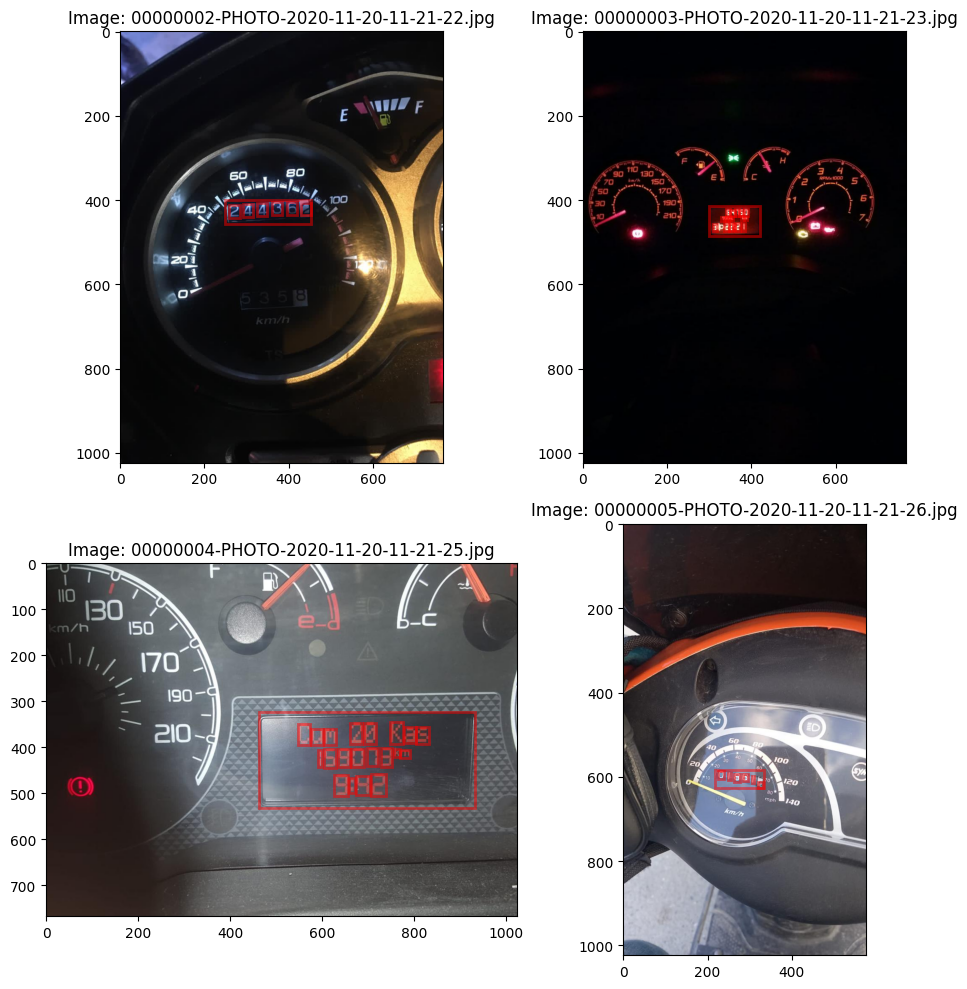

In [ ]:
figure_size = (10, 10)

num_rows = 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=figure_size)

axes = axes.flatten()

for i, image_name in enumerate(sample_images):
    image_path = os.path.join(dataset_folder_path, 'images', image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    xml_file_path = os.path.join(dataset_folder_path, 'pascal voc 1.1', 'Annotations', f"{os.path.splitext(image_name)[0]}.xml")

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    annotations = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        odometer_type = obj.find('name').text
        annotations.append({'odometer_type': odometer_type, 'bbox': [xmin, ymin, xmax, ymax]})

    axes[i].imshow(image)
    axes[i].set_title(f"Image: {image_name}")

    for idx, annotation in enumerate(annotations):
        odometer_type = annotation['odometer_type']
        bbox = annotation['bbox']

        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), width=xmax - xmin, height=ymax - ymin,
                             edgecolor='r', linewidth=2, fill=False, alpha=0.5)
        axes[i].add_patch(rect)

plt.tight_layout()

plt.show()

In [ ]:
for x in groundtruth_data['odometers'][:4]:
  print(x["mileage"])

244362
64750
159073
18613


# 3- Data Preprocessing

## Parallelize Preprocessing:


Install tqdm library for tracking process

for the better preprocessing: only take the odometer part of image into the consideration, then resize.
EXTRA CODE::::

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from joblib import Parallel, delayed

def preprocess_image(image_path, xml_file_path, target_size=(224, 224)):
    # Read the image
    img = cv2.imread(image_path)

    # Parse the XML file to get the first bounding box coordinates
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Find all object (bounding box) in the XML file with name 'odometer'
    objects = root.findall('object')
    objects = [obj for obj in objects if obj.find('name').text == 'odometer']

    # Crop the image to the specified bounding box
    for obj in objects:
        bbox = [float(obj.find('bndbox').find(coord).text) for coord in ['xmin', 'ymin', 'xmax', 'ymax']]
        cropped_img = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]

        # Resize the cropped image
        resized_img = cv2.resize(cropped_img, target_size)

        # Normalize pixel values to be between 0 and 1
        normalized_img = resized_img / 255.0

        return normalized_img

    # Return None if no bounding box is found
    return None

# Define a parallelized version of the preprocessing function
def preprocess_image_parallel(odometer):
    image_name = odometer['image']
    image_path = os.path.join(dataset_folder_path, 'images', image_name)
    xml_file_path = os.path.join(dataset_folder_path, 'pascal voc 1.1', 'Annotations', f"{os.path.splitext(image_name)[0]}.xml")

    # Preprocess the image and return result
    return preprocess_image(image_path, xml_file_path)

# Use parallel processing with tqdm for preprocessing
X = Parallel(n_jobs=-1)(delayed(preprocess_image_parallel)(odometer) for odometer in tqdm(groundtruth_data['odometers'], desc="Preprocessing", position=0, leave=True))

# Remove None values from X (images with no bounding boxes)
X = [img for img in X if img is not None]

# Append the odometer types to y
y = [odometer['odometer_type'] for odometer in groundtruth_data['odometers']]


Preprocessing: 100%|██████████| 2389/2389 [07:23<00:00,  5.39it/s]


Outputs of images after preprocessing:

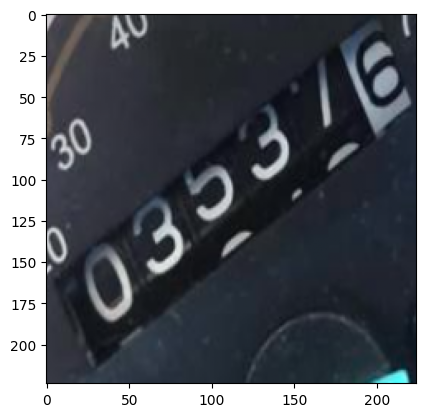

In [ ]:
plt.imshow(X[4])

 Convert string labels to numeric labels


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y)

the mapping between original labels and numeric labels

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'analog': 0, 'digital': 1}


In [ ]:
X[4]

array([[[0.80784314, 0.79607843, 0.80392157],
        [0.79607843, 0.78431373, 0.79607843],
        [0.80784314, 0.79215686, 0.81176471],
        ...,
        [0.18823529, 0.21176471, 0.24313725],
        [0.15294118, 0.17254902, 0.20784314],
        [0.16078431, 0.18039216, 0.21568627]],

       [[0.81176471, 0.8       , 0.80784314],
        [0.80392157, 0.79215686, 0.8       ],
        [0.78823529, 0.77254902, 0.79215686],
        ...,
        [0.17647059, 0.19607843, 0.23137255],
        [0.15686275, 0.17647059, 0.21176471],
        [0.14117647, 0.16078431, 0.19607843]],

       [[0.81176471, 0.79607843, 0.80392157],
        [0.80784314, 0.79607843, 0.80784314],
        [0.78039216, 0.76470588, 0.78431373],
        ...,
        [0.16078431, 0.18039216, 0.21568627],
        [0.14901961, 0.16862745, 0.20392157],
        [0.14117647, 0.16078431, 0.19607843]],

       ...,

       [[0.20784314, 0.21568627, 0.25490196],
        [0.20784314, 0.21568627, 0.25882353],
        [0.21568627, 0

In [ ]:
y[4]

'analog'

## Save and load the preprocessed data

To avoid re-running the preprocessing cell every time I write a python script that saves the output of this code:

load the processed data in a future session

In [ ]:
import pickle
from google.colab import drive

drive.mount('/content/drive')

# Save the processed data to Google Drive
file_path = '/content/drive/MyDrive/processed_data.pkl'
#with open(file_path, 'wb') as f:
#    pickle.dump(X, f)
#    pickle.dump(y, f)

# To load the processed data in a future session
with open(file_path, 'rb') as f:
    X = pickle.load(f)
    y = pickle.load(f)


Mounted at /content/drive


## Split the dataset into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train[0]

array([[[0.00392157, 0.01960784, 0.12156863],
        [0.        , 0.01176471, 0.10980392],
        [0.        , 0.03529412, 0.11764706],
        ...,
        [0.        , 0.04313725, 0.09803922],
        [0.        , 0.03921569, 0.09411765],
        [0.        , 0.04705882, 0.10196078]],

       [[0.02745098, 0.03529412, 0.14509804],
        [0.        , 0.01176471, 0.12156863],
        [0.00784314, 0.05882353, 0.16078431],
        ...,
        [0.        , 0.03921569, 0.09411765],
        [0.        , 0.03529412, 0.09019608],
        [0.        , 0.04313725, 0.09803922]],

       [[0.00392157, 0.1254902 , 0.30196078],
        [0.        , 0.0745098 , 0.23921569],
        [0.        , 0.05098039, 0.2       ],
        ...,
        [0.01176471, 0.0627451 , 0.11764706],
        [0.        , 0.04705882, 0.10196078],
        [0.        , 0.03921569, 0.09411765]],

       ...,

       [[0.        , 0.07058824, 0.19215686],
        [0.00392157, 0.07843137, 0.21176471],
        [0.03137255, 0

In [ ]:
y_train[0]

'digital'

## Label Encodings

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)

X_train_array = np.array(X_train)
y_train_array = np.array(y_train_numeric)

y_test_numeric = label_encoder.transform(y_test)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test_numeric)

In [ ]:
X_test_array[0]

array([[[0.48235294, 0.46666667, 0.4627451 ],
        [0.5372549 , 0.52156863, 0.51764706],
        [0.66666667, 0.65098039, 0.64705882],
        ...,
        [0.42745098, 0.43137255, 0.45098039],
        [0.42745098, 0.43529412, 0.4627451 ],
        [0.43137255, 0.43921569, 0.47058824]],

       [[0.48235294, 0.46666667, 0.4627451 ],
        [0.5372549 , 0.52156863, 0.51764706],
        [0.66666667, 0.65098039, 0.64705882],
        ...,
        [0.42352941, 0.43137255, 0.45098039],
        [0.43137255, 0.43529412, 0.46666667],
        [0.43137255, 0.43921569, 0.47058824]],

       [[0.48235294, 0.46666667, 0.4627451 ],
        [0.5372549 , 0.52156863, 0.51764706],
        [0.66666667, 0.65098039, 0.64705882],
        ...,
        [0.42745098, 0.43137255, 0.45098039],
        [0.43137255, 0.43529412, 0.46666667],
        [0.43137255, 0.43921569, 0.47058824]],

       ...,

       [[0.42352941, 0.41960784, 0.43529412],
        [0.41960784, 0.41568627, 0.43137255],
        [0.40784314, 0

In [ ]:
y_train_numeric[0]

1

Flatten each image on train set


In [ ]:
X_train_flat = np.reshape(X_train_array, (X_train_array.shape[0], -1))
X_test_flat = np.reshape(X_test_array, (X_test_array.shape[0], -1))

# 4- Train and Evaluate the Models


## KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
import numpy as np


# Initialize the KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# Fit the model with tqdm progress bar
for epoch in tqdm(range(10), desc="Fitting KNN", position=0, leave=True):
    knn_clf.fit(X_train_flat, y_train_array)

# Calculate baseline accuracy
baseline_accuracy = knn_clf.score(X_test_flat, y_test_array)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")


Fitting KNN:   0%|          | 0/10 [00:00<?, ?it/s]

Baseline Accuracy: 0.8661


Find the best parameters using GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train_flat, y_train_array)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'uniform'}

In [ ]:
grid_search.best_score_


0.9000451109318824

In [ ]:
grid_search.best_estimator_.fit(X_train_flat, y_train_array)
tuned_accuracy = grid_search.score(X_test_flat, y_test_numeric)
tuned_accuracy

0.9037656903765691

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming grid_search.best_estimator_ is your model
y_pred = grid_search.best_estimator_.predict(X_test_flat)

accuracy = accuracy_score(y_test_numeric, y_pred)
precision = precision_score(y_test_numeric, y_pred, average='binary')
recall = recall_score(y_test_numeric, y_pred, average='binary')
f1 = f1_score(y_test_numeric, y_pred, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9037656903765691
Precision: 0.8735294117647059
Recall: 0.99
F1 Score: 0.928125


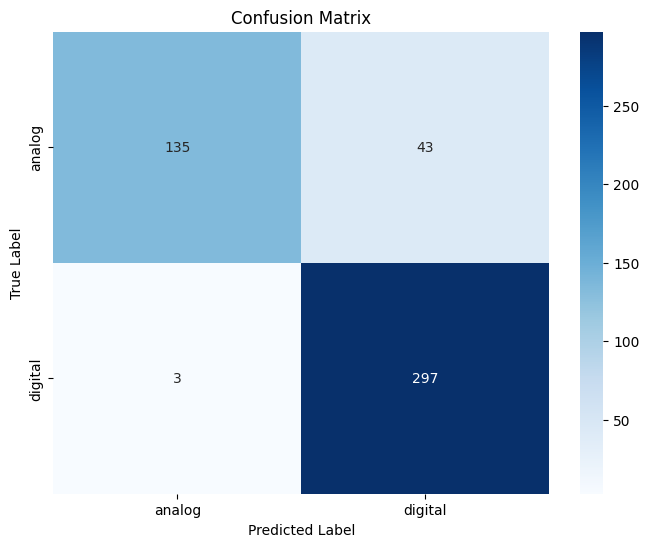

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming grid_search.best_estimator_ is your model
y_pred = grid_search.best_estimator_.predict(X_test_flat)

# Use the label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
class_labels = list(label_mapping.keys())

# Do not remap the labels, use them directly
y_test_numeric_mapped = y_test_numeric
y_pred_mapped = y_pred

# Compute confusion matrix
cm = confusion_matrix(y_test_numeric_mapped, y_pred_mapped)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


As we can see on outputs KNN provides a better performance with tuned parameters

## Random Forest Classifier

In [ ]:
# Sample a smaller subset of data
# sample_size = 1000  # Adjust based on your available resources
X_train_sample = X_train_flat
y_train_sample = y_train_array

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Reduce the hyperparameter grid size
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier()

# Create GridSearchCV without tqdm callback
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=3, verbose=2, n_jobs=-1)

# Fit the model without tqdm callback
grid_search_rf.fit(X_train_sample, y_train_sample)
baseline_accuracy = grid_search_rf.score(X_test_flat, y_test_array)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f"Best Parameters for RandomForestClassifier: {best_params_rf}")

# Fit the best model
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train_flat, y_train_array)

# Calculate tuned accuracy
tuned_accuracy_rf = best_rf_model.score(X_test_flat, y_test_numeric)
print(f"Tuned Accuracy for RandomForestClassifier: {tuned_accuracy_rf:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Baseline Accuracy: 0.9749
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Accuracy for RandomForestClassifier: 0.9791


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions on the test set using the tuned RandomForestClassifier
y_pred_rf = best_rf_model.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(y_test_array, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_test_array, y_pred_rf)
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test_array, y_pred_rf)
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_test_array, y_pred_rf)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_array, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9791
Precision: 0.9966
Recall: 0.9700
F1 Score: 0.9831
Confusion Matrix:
[[177   1]
 [  9 291]]


## CNN

Alternative way with Early Stopping:

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you've defined model as mentioned in the previous code

# Ensure the output layer is configured for binary classification
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Change the number of units to 1 for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
model.fit(X_train_array, y_train_array, epochs=10, validation_data=(X_test_array, y_test_array), callbacks=[checkpoint, early_stopping])

# Load the best weights after training
best_model = load_model('best_model.h5')

# Make predictions on the test set
y_pred_proba = best_model.predict(X_test_array)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Ensure y_pred is a 1D array

# Convert y_test_array to match the binary format
y_test_binary = y_test_array.flatten()  # Ensure y_test_binary is a 1D array

# Calculate metrics
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
conf_matrix = confusion_matrix(y_test_binary, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Epoch 1/10
58/60 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.9025

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 5s 45ms/step - loss: 0.2625 - accuracy: 0.9037 - val_loss: 0.0663 - val_accuracy: 0.9728
Epoch 2/10
60/60 [==============================] - 2s 29ms/step - loss: 0.0486 - accuracy: 0.9853 - val_loss: 0.0162 - val_accuracy: 0.9874
Epoch 3/10
60/60 [==============================] - 2s 35ms/step - loss: 0.0201 - accuracy: 0.9937 - val_loss: 0.0076 - val_accuracy: 0.9979
Epoch 4/10
60/60 [==============================] - 2s 28ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/10
60/60 [==============================] - 1s 21ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0038 - val_accuracy: 0.9979
Epoch 6/10
60/60 [==============================] - 2s 30ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 7/10
60/60 [==============================] - 1s 21ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.2147 - val_accuracy: 0.9519
Epoch 8/10
60/60 [======

In [ ]:
model.load_weights('best_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               